# Hiearchical Modeling of Batting Averages

### Data Source:
http://www.seanlahman.com/baseball-archive/statistics/

Before running this notebook, make sure to download the data file from [here](https://github.com/jknecht/baseball-archive-sqlite/blob/master/lahman2016.sqlite) and put it in the same folder as this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

import sqlite3

# Connecting to SQLite Database
conn = sqlite3.connect('lahman2016.sqlite')

In [2]:
# Querying Database for all seasons where a team played 150 or more games and is still active today. 
query = '''SELECT playerID, yearID, AB, H
           FROM Batting
           WHERE yearID >= 2016
           ORDER BY HR DESC;
'''

# Creating dataframe from query.
bats = conn.execute(query).fetchall()

df = pd.DataFrame(bats, columns=['Name','Year','AtBats','Hits'])

df.head()

,Name,Year,AtBats,Hits
0,trumbma01,2016,613,157
1,cruzne02,2016,589,169
2,daviskh01,2016,555,137
3,doziebr01,2016,615,165
4,encared01,2016,601,158


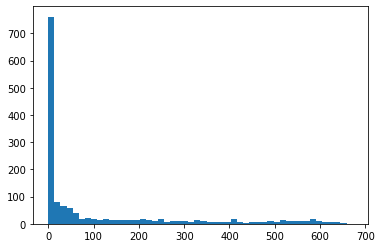

In [4]:
plt.hist(df['AtBats'], 50)
plt.show()

In [5]:
df = df.loc[ df['AtBats']>5 ]

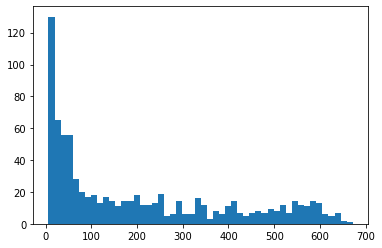

In [6]:
plt.hist(df['AtBats'],50)
plt.show()

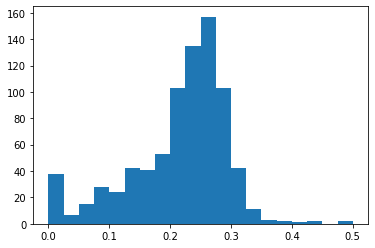

In [8]:
batting_avg = df['Hits']/df['AtBats']

plt.hist(batting_avg, 20)
plt.show()

In [9]:
bad_hitters = df.loc[ batting_avg<0.05 ]
bad_hitters.head()

,Name,Year,AtBats,Hits
479,gallojo01,2016,25,1
548,aguilje01,2016,6,0
572,archech01,2016,7,0
608,bettich01,2016,49,2
611,blairaa01,2016,21,1


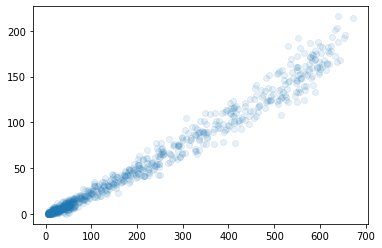

In [14]:
plt.scatter(df['AtBats'], df['Hits'], alpha=0.1)
plt.show()

# Set up for Gibbs Sampler

In [34]:
def SampleProbs(atbats, hits, alpha, beta):
    
    # Compute the conditional parameters for each player
    new_alphas = alpha + hits 
    new_betas =  alpha + atbats-hits
    
    # Draw a random sample of the conditional distribution
    samps = st.beta.rvs(new_alphas, new_betas)
    return samps
    
def SampleHyperParameters(probs, curr_alpha, curr_beta):
    prop_std = 0.5
    
    alpha_k = 5.0
    alpha_theta = 5.0 
    beta_k = 5.0
    beta_theta = 5.0
    
    prop_alpha = curr_alpha + prop_std*np.random.randn()
    prop_beta = curr_beta + prop_std*np.random.randn()
    
    # Evaluate the Gamma hyper-prior
    if((prop_alpha<0.0)|(prop_beta<0.0)):
        return curr_alpha, curr_beta
    
    prop_log_prior  = st.gamma.logpdf(prop_alpha, alpha_k, scale=alpha_theta)
    prop_log_prior += st.gamma.logpdf(prop_beta, beta_k, scale=beta_theta)
    
    old_log_prior  = st.gamma.logpdf(curr_alpha, alpha_k, scale=alpha_theta)
    old_log_prior += st.gamma.logpdf(curr_beta, beta_k, scale=beta_theta)
        
    # Evaluate the log-likelihood function (which is just the likelihood of the probs)
    old_log_likely = np.sum( st.beta.logpdf(probs, curr_alpha, curr_beta) )
    prop_log_likely = np.sum( st.beta.logpdf(probs, prop_alpha, prop_beta) )
    
    # Log post
    old_log_post = old_log_likely + old_log_prior
    prop_log_post = prop_log_likely + prop_log_prior
    
    # Use the Metropolis-Hastings rule to accept/reject
    gamma = np.exp(prop_log_post - old_log_post)
    if(np.random.rand() < gamma):
        return prop_alpha,  prop_beta
    else:
        return curr_alpha, curr_beta

In [35]:
obs_bats = df['AtBats'].to_numpy()
obs_hits = df['Hits'].to_numpy()

num_players = df.shape[0]

num_samps = 1000

curr_alpha = 2.0
curr_beta = 5.0

all_samps = np.zeros((num_samps, num_players+2))
all_samps[0,-2] = 1.0 # Initial value for alpha
all_samps[0,-1] = 1.0 # Intial value for beta

for i in range(num_samps-1):
    all_samps[i+1,:-2] = SampleProbs(obs_bats, obs_hits, curr_alpha, curr_beta)
    all_samps[i+1,-2], all_samps[i+1,-1] = SampleHyperParameters(all_samps[i+1,:-2], all_samps[i,-2], all_samps[i,-1])
    
print('Posterior Mean (alpha,beta) = ', np.mean(all_samps[:,-2:],axis=0))



Posterior Mean (alpha,beta) =  [ 5.34474749 16.64363287]


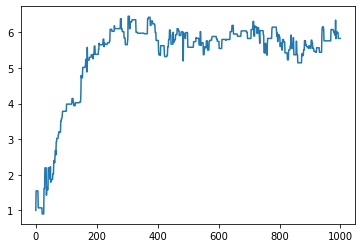

In [37]:
plt.plot(all_samps[:,-2])
plt.show()

In [38]:
burn_in = 250
avg_batting_avgs = np.mean(all_samps[burn_in:,0:-2],axis=0)

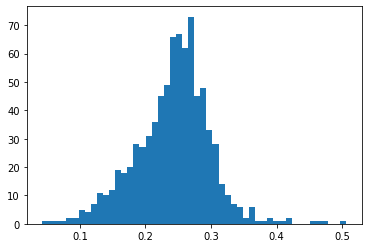

In [40]:
plt.hist(avg_batting_avgs,50)
plt.show()

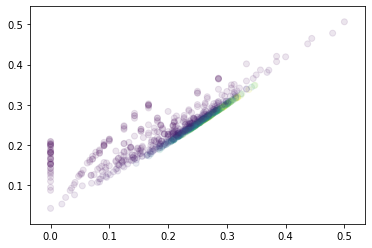

In [43]:
plt.scatter(batting_avg,avg_batting_avgs, c=df['AtBats'], alpha=0.1)
plt.show()